In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objs as go
import copy
import os
import torch
from PIL import Image
from torch.utils.data import random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn as nn
from torchvision import utils
from torchvision import datasets, transforms
%matplotlib inline

In [2]:
DATA_DIR = '../input/ball-dataset/'
os.listdir(DATA_DIR)

['legal ball', 'no ball']

In [3]:
no_ball = os.listdir(DATA_DIR+'no ball')
legal_ball = os.listdir(DATA_DIR+'legal ball')
len(no_ball), len(legal_ball)

(52, 25)

Unbalanced dataset, we need to take this into account so that our model doesn't unfairly be biased towards `no balls`

Image shape:  (172, 293, 3)
Image shape:  (165, 305, 3)
Image shape:  (165, 305, 3)
Image shape:  (168, 299, 3)
Image shape:  (166, 303, 3)
Image shape:  (168, 299, 3)


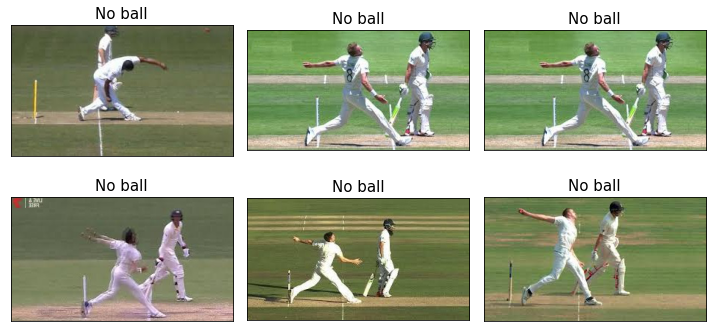

In [4]:
fig = plt.figure(figsize=(10, 5))
for i, file in enumerate(no_ball[5:11]):
  img = Image.open(DATA_DIR+'no ball/'+file)
  print('Image shape: ', np.array(img).shape)
  ax = fig.add_subplot(2, 3, i+1)
  ax.set_xticks([])
  ax.set_yticks([])
  ax.imshow(img)
  ax.set_title('No ball', size=15)
plt.tight_layout()
plt.show()

Image shape:  (1080, 1920, 3)
Image shape:  (667, 1200, 3)
Image shape:  (601, 1000, 3)
Image shape:  (900, 1200, 3)
Image shape:  (186, 271, 3)
Image shape:  (183, 275, 3)


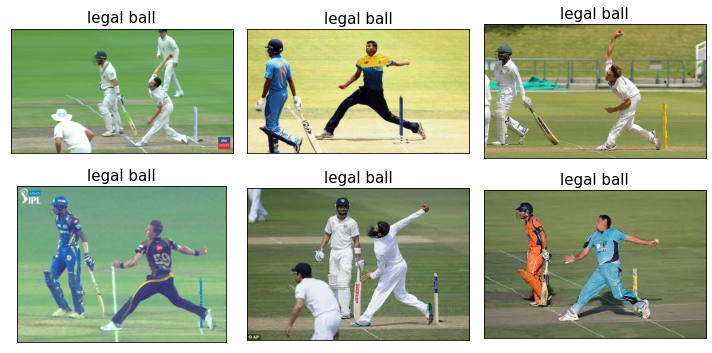

In [5]:
fig = plt.figure(figsize=(10, 5))
for i, file in enumerate(legal_ball[5:11]):
  img = Image.open(DATA_DIR+'legal ball/'+file)
  print('Image shape: ', np.array(img).shape)
  ax = fig.add_subplot(2, 3, i+1)
  ax.set_xticks([])
  ax.set_yticks([])
  ax.imshow(img)
  ax.set_title('legal ball', size=15)
plt.tight_layout()
plt.show()

# Data loading and preprocessing

In [6]:
def readImg(path):
    img = Image.open(path)
    return img
    
    

In [7]:
transform = transforms.Compose([transforms.Resize((128,128),interpolation=Image.Resampling.NEAREST),
                                transforms.RandomHorizontalFlip(p=0.5),
                                transforms.Grayscale(),
                                 transforms.ToTensor()])

/opt/conda/lib/python3.7/site-packages/torchvision/transforms/transforms.py:333: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


In [8]:
dataset = datasets.ImageFolder(DATA_DIR, transform=transform, loader=readImg)

In [9]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

In [10]:
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

tensor(1)


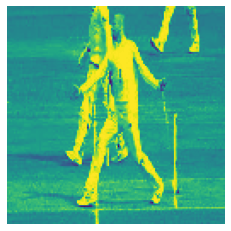

In [11]:
# Run this to test your data loader
images, labels = next(iter(dataloader))
# helper.imshow(images[0], normalize=False)
imshow(images[0], normalize=False)
print(labels[1])

In [12]:
for img, label in dataloader:
    print(label)

tensor([1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1,
        1, 1, 0, 1, 0, 0, 0, 1])
tensor([1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0,
        1, 1, 0, 0, 1, 1, 0, 1])
tensor([0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0])


In [13]:
dataset.class_to_idx

{'legal ball': 0, 'no ball': 1}

# train test split

In [14]:
len_img=len(dataset)
len_train=int(0.8*len_img)
len_val=len_img-len_train

# Split Pytorch tensor
train_ts,val_ts=random_split(dataset,
                             [len_train,len_val]) # random split 80/20

print("train dataset size:", len(train_ts))
print("validation dataset size:", len(val_ts))

train dataset size: 61
validation dataset size: 16


# Data Augmentations of the train set
